## Refreshment Project 2.0 - Home Prices Prediction - Ames Housing

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

In [63]:
df = pd.read_csv("AmesHousing.csv")
print("shape:", df.shape)
df.head()

shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [64]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

In [65]:
df_numeric.corr()["SalePrice"].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Screen Porch       0.112151
Pool Area          0.068403
Mo Sold            0.035259
3Ssn Porch         0.032225
BsmtFin SF 2       0.005891
Misc Val          -0.015691
Yr Sold           -0.030569
Order             -0.031408
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0

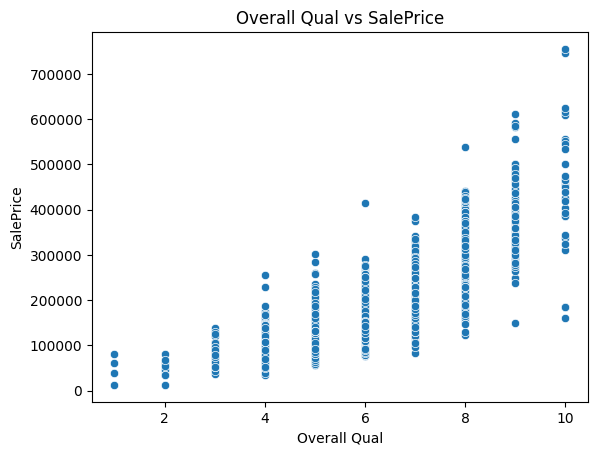

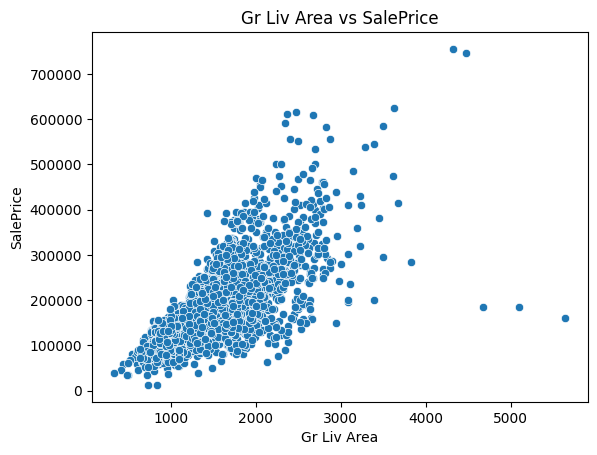

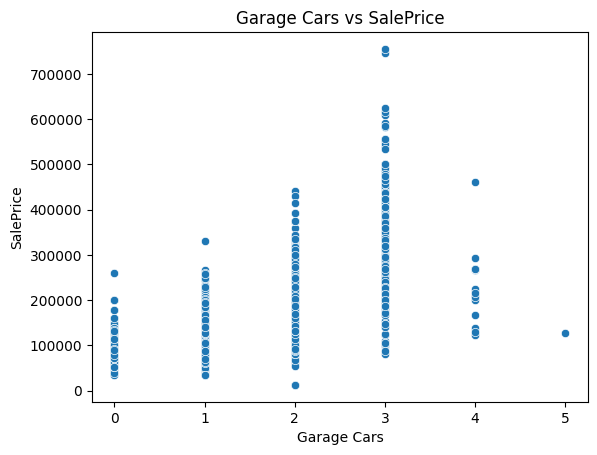

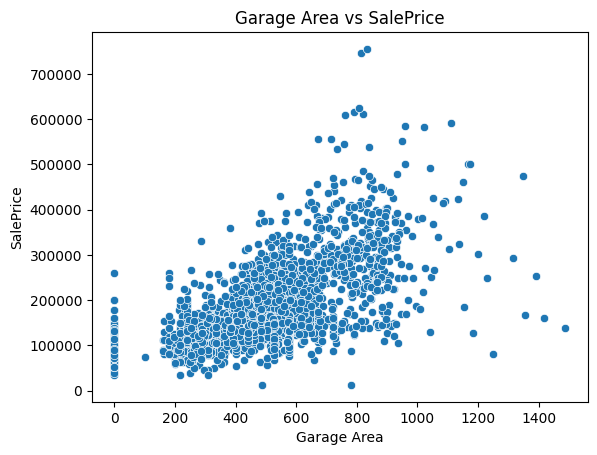

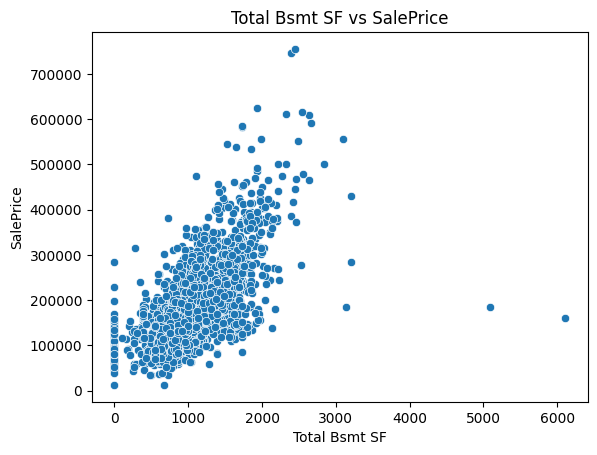

In [66]:
important_features = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Garage Area", "Total Bsmt SF"]
for col in important_features:
    sns.scatterplot(data=df, x=col, y="SalePrice")
    plt.title(f"{col} vs SalePrice")
    plt.show()


### NA Handling

In [67]:
df.isna().sum().sort_values(ascending=False)

Pool QC         2917
Misc Feature    2824
Alley           2732
Fence           2358
Mas Vnr Type    1775
                ... 
PID                0
Central Air        0
1st Flr SF         0
2nd Flr SF         0
SalePrice          0
Length: 82, dtype: int64

In [68]:
na_pct = df.isna().mean() * 100
na_over_30 = na_pct[na_pct > 30].sort_values(ascending=False)
print(na_over_30)

Pool QC         99.556314
Misc Feature    96.382253
Alley           93.242321
Fence           80.477816
Mas Vnr Type    60.580205
Fireplace Qu    48.532423
dtype: float64


#### dropping columns with more than 30% of NA values

In [69]:
df = df.drop(columns=["Pool QC", "Misc Feature", "Alley", "Fence", "Mas Vnr Type", "Fireplace Qu"])

#### filling NA in Lot Frontage by the Neightborhood column

In [70]:
df["Lot Frontage"].value_counts()

Lot Frontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
119.0      1
137.0      1
25.0       1
152.0      1
133.0      1
Name: count, Length: 128, dtype: int64

In [71]:
df[["Lot Frontage", "Neighborhood"]]

,Lot Frontage,Neighborhood
0,141.0,NAmes
1,80.0,NAmes
2,81.0,NAmes
3,93.0,NAmes
4,74.0,Gilbert
...,...,...
2925,37.0,Mitchel
2926,NaN,Mitchel
2927,62.0,Mitchel
2928,77.0,Mitchel


In [72]:
df["Lot Frontage"] = df["Lot Frontage"].fillna(df.groupby("Neighborhood")["Lot Frontage"].transform("median"))

In [73]:
#check
df["Lot Frontage"].isna().sum()

3

#### still 3 nans - will use overall median to fill missing values

In [74]:
med_lf = df["Lot Frontage"].median()
df["Lot Frontage"] = df["Lot Frontage"].fillna(med_lf)

In [75]:
df["Lot Frontage"].isna().sum()
#0

0

#### handling Nan with "None" in object columns

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2930 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

In [77]:
df_object_cols = df.select_dtypes(include=["object"]).columns


In [78]:
df[df_object_cols] = df[df_object_cols].fillna("None")

In [79]:
df_object_cols.isna().sum()

0

In [80]:
df.isna().sum().sort_values(ascending=False).head(10)


Garage Yr Blt     159
Mas Vnr Area       23
Bsmt Half Bath      2
Bsmt Full Bath      2
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
Garage Cars         1
Garage Area         1
dtype: int64

In [81]:
cols_to_fill = [
    "Garage Yr Blt", "Mas Vnr Area", "Bsmt Half Bath", "Bsmt Full Bath",
    "Total Bsmt SF", "Bsmt Unf SF", "BsmtFin SF 2", "BsmtFin SF 1",
    "Garage Cars", "Garage Area"
]

for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].median())


In [82]:
df.isna().sum().sort_values(ascending=False)

Order            0
Full Bath        0
Fireplaces       0
Functional       0
TotRms AbvGrd    0
                ..
Exterior 2nd     0
Exterior 1st     0
Roof Matl        0
Roof Style       0
SalePrice        0
Length: 76, dtype: int64

### Feature Engineering

In [ ]:
#1. TotalSF

df["TotalSF"] = df["Total Bsmt SF"] + df["1st Flr SF"] + df["2nd Flr SF"]

In [ ]:
#drop redundand columns:
df = df.drop(columns=["Total Bsmt SF","1st Flr SF", "2nd Flr SF"],errors="ignore")

In [86]:
#2. TotalBathrooms

df["TotalBathrooms"] = df["Full Bath"] + df["Half Bath"]*0.5 + df["Bsmt Full Bath"] + df["Bsmt Half Bath"]*0.5

In [87]:
df = df.drop(columns=["Full Bath", "Half Bath", "Bsmt Full Bath", "Bsmt Half Bath"], errors="ignore")